# BrainSpace surface plot example: Human Connectome Project (HCP) 

Most of the code was copyed from NMA-
The HCP dataset comprises resting-state and task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In [1]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Necessary for visualization
!pip install nilearn --quiet
!pip install brainspace --quiet
from nilearn import plotting, datasets

# Surface plot with BrainSpace
from brainspace.datasets import load_conte69
from brainspace.plotting import plot_hemispheres, plot_surf
from brainspace.utils.parcellation import map_to_labels
from brainspace.mesh import mesh_cluster
from brainspace.gradient import GradientMaps
import panel as pn
pn.extension('vtk')
import csv
import urllib.request as urllib2

# matplotlib
import matplotlib.pyplot as plt # For changing the color maps
from matplotlib import cm # cm=colormap
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


In [2]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

# Basic parameters

In [3]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

# Downloading data

The rest and task data are shared in different files, but they will unpack into the same directory structure.

Each file is fairly large and will take some time to download. If you are focusing only on rest or task analyses, you may not want to download only that dataset.

We also separately provide some potentially useful behavioral covariate information.

In [4]:
fname = "hcp_rest.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/bqp7m/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [5]:
fname = "hcp_task.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/s4h8j/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [6]:
fname = "hcp_covariates.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/x5p4g/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [7]:
fname = f"{HCP_DIR}/atlas.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/j5kuc/download

## Loading region information

Downloading either dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).

In [8]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    myelin=regions[2].astype(np.float),
)

We also provide the [parcellation on the fsaverage5 surface](https://figshare.com/articles/HCP-MMP1_0_projected_on_fsaverage/3498446) and approximate MNI coordinates of each region, which can be useful for visualization:

In [9]:
with np.load(f"{HCP_DIR}/atlas.npz") as dobj:
  atlas = dict(**dobj)

# Helper functions


## Data loading

In [10]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
    i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
  ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}''")
  return run_ids

def load_timeseries(subject, name, runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.
  
  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment 
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
      load_single_timeseries(subject, offset + run, remove_mean) for run in runs
  ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

def load_evs(subject, name, condition):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{condition}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    evs.append(ev)
  return evs

## Task-based analysis

In [11]:
def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev, skip)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    run_frames = run_frames[run_frames < run_data.shape[1]]
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

# Resting-state analyses

Load a single run of resting-state data:

In [12]:
help(load_timeseries)

Help on function load_timeseries in module __main__:

load_timeseries(subject, name, runs=None, concat=True, remove_mean=True)
    Load timeseries data for a single subject.
    
    Args:
      subject (int): 0-based subject ID to load
      name (str) : Name of experiment ("rest" or name of task) to load
      run (None or int or list of ints): 0-based run(s) of the task to load,
        or None to load all runs.
      concat (bool) : If True, concatenate multiple runs in time
      remove_mean (bool) : If True, subtract the parcel-wise mean
    
    Returns
      ts (n_parcel x n_tp array): Array of BOLD data values



In [13]:
timeseries = load_timeseries(subject=0, name="rest", runs=1)
print(timeseries.shape)  # n_parcel x n_timepoint

(360, 1200)


Load a concatenated resting-state timeseries (using all runs' data) for each subject:

In [14]:
timeseries_rest = []
for subject in subjects:
  ts_concat = load_timeseries(subject, "rest")
  timeseries_rest.append(ts_concat)

## Run a simple correlation-based "functional connectivity" analysis

Generate a correlation matrix (showing "functional connectivity" or FC) for each subject and plot the group average:

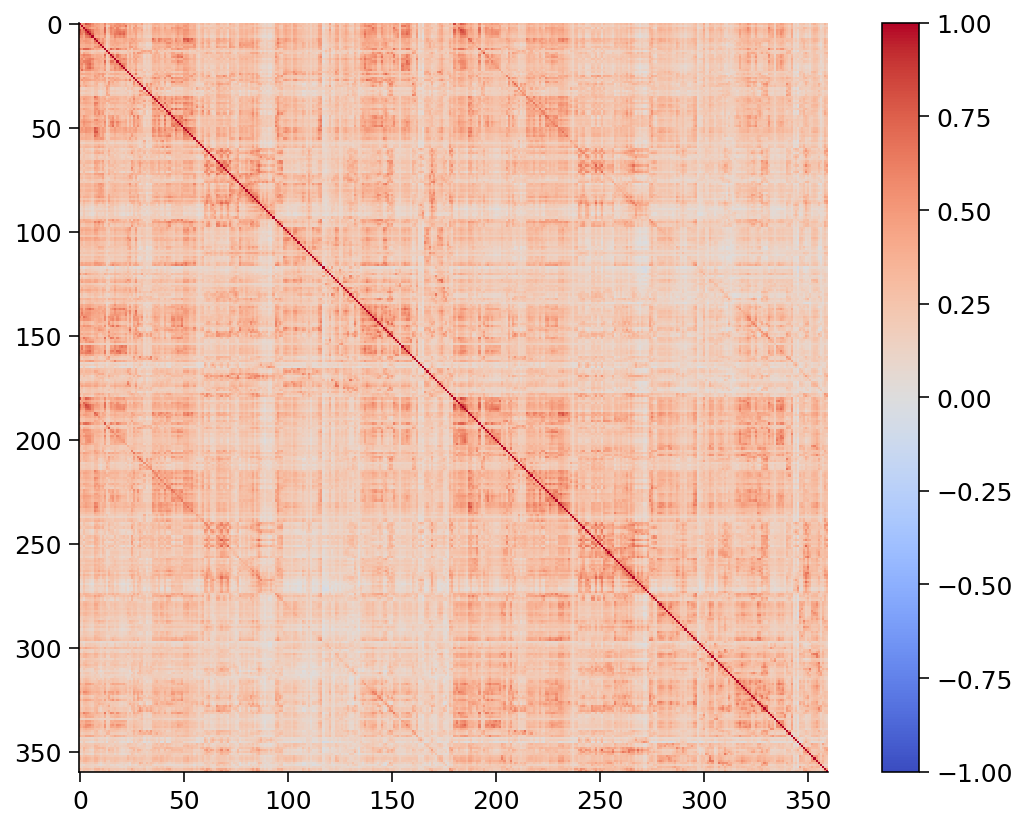

In [15]:
fc = np.zeros((N_SUBJECTS, N_PARCELS, N_PARCELS))
for sub, ts in enumerate(timeseries_rest):
  fc[sub] = np.corrcoef(ts)

group_fc = fc.mean(axis=0)

plt.imshow(group_fc, interpolation="none", cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

# Plot the nodal degree of the functional connectivity matrix
The degree refers to the number of links connected to a node.  
The weighted degree of a node is defined as:  
$$i, K_i^w = \sum_{j \in N} w_{ij}$$

In [16]:
# @title load conte 69
# First load the Glasser annotation file
file_url='https://raw.githubusercontent.com/rcruces/2020_NMA_surface-plot/master/data/glasser_360_conte69.csv'
Glasser = np.loadtxt(urllib2.urlopen(file_url), dtype=np.int)
# and load the conte69 surfaces
surf_lh, surf_rh = load_conte69()
# Mask the 0-value ROI of the medial wall
mask = Glasser != 0
# Create an array of the ROI unique values (Nrois x 1, float)
GlasserROIs = np.asarray(np.unique(Glasser), dtype=float)
# Map ROI values to vertices indexes (Nvertices x 1)
Glasser_masked = map_to_labels(GlasserROIs, Glasser, mask=mask, fill=np.nan)

/opt/anaconda3/lib/python3.7/site-packages/vtk-8.1.2-py3.7-macosx-10.9-x86_64.egg/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


/opt/anaconda3/lib/python3.7/site-packages/brainspace-0.1.1-py3.7.egg/brainspace/plotting/base.py:292: UserWarning: Support for interactive mode is only provided for a single renderer: 'nrow=1' and 'ncol=1'. Setting 'interactive=False'
  warnings.warn("Support for interactive mode is only provided for "


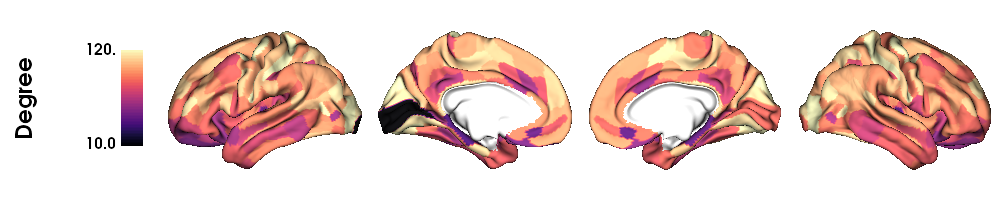

In [17]:
# I used the absolute value to facilitate the calculation 
# this is not optimal, is only use as a visualization example
Degree = np.append(0, abs(group_fc).sum(axis=0))

# map the nodal degree to the vertices
DegreeVertx = map_to_labels(Degree, Glasser, mask=mask, fill=np.nan)

# Plot Surface
plot_hemispheres(surf_lh, surf_rh, array_name=DegreeVertx, size=(1000, 200), label_text={'left':['Degree']},
                 embed_nb=True, cmap='magma', color_bar='left',color_range=(10,120), zoom=1.25, nan_color=(1, 1, 1, 1)
                )

# Non-linear dimentionality reduction: Diffusion Maps
Here we calculate the gradients over the group connectivity matrix. For further information check the [BrainSpace webpage](https://brainspace.readthedocs.io/en/latest/index.html) 

In [22]:
from brainspace.gradient import GradientMaps
# Calculate the gradient
gm = GradientMaps(n_components=3, random_state=0)
gm.fit(group_fc)

# Map gradients to original parcels
grad = [None] * 3
for i, g in enumerate(gm.gradients_.T):
    grad[i] = map_to_labels(g, Glasser, mask=mask, fill=np.nan)

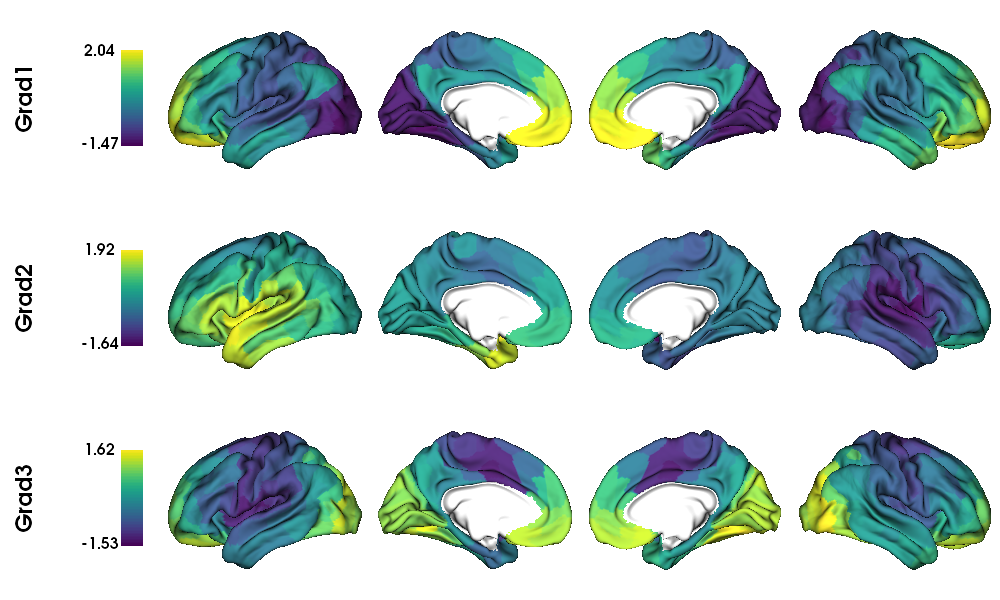

In [23]:
# Plot Gradients
plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1000, 600), cmap='viridis',
                 embed_nb=True,  label_text={'left':['Grad1', 'Grad2','Grad3']}, color_bar='left', 
                 zoom=1.25, nan_color=(1, 1, 1, 1)
                )